GIF guardado como 'evolution.gif' en la ruta del proyecto.


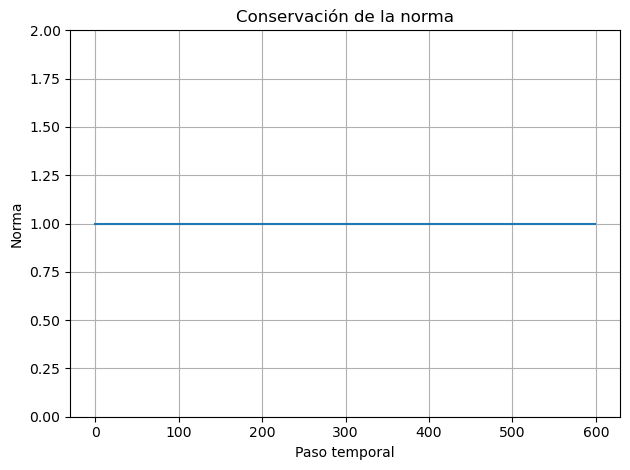

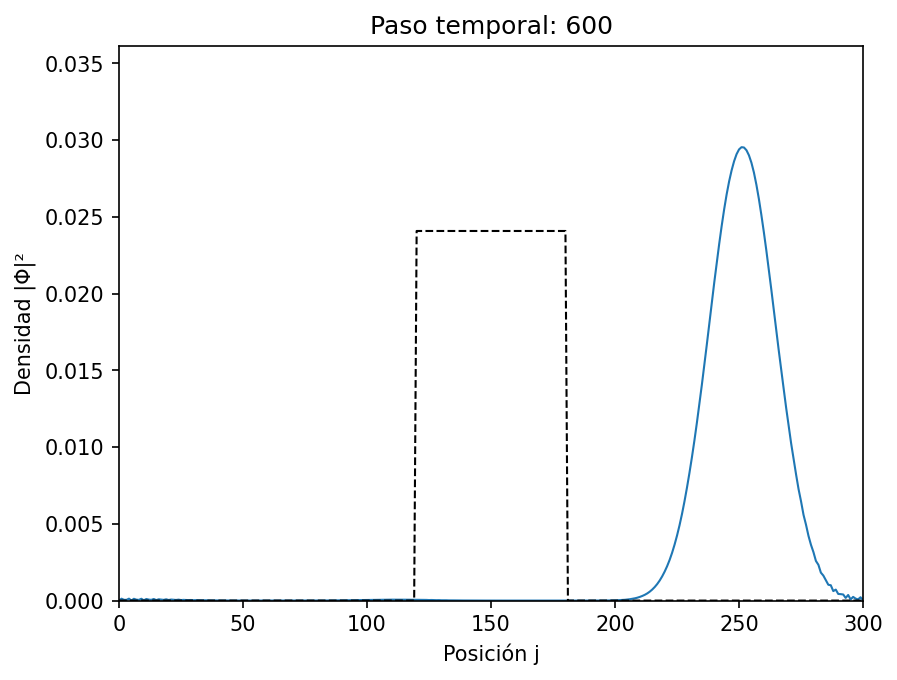

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# =============================================================
# Simulación de la ecuación de Schrödinger 1D
# Método de Crank-Nicolson (aproximación de Cayley) con animación
# =============================================================

# 1. Parámetros iniciales
def initialize_parameters(N, nciclos, lam):
    k0_tilde = 2 * np.pi * nciclos / N
    V_tilde = np.zeros(N + 1)
    j1, j2 = int(2 * N / 5), int(3 * N / 5)
    V_tilde[j1:j2 + 1] = lam * k0_tilde ** 2
    s_tilde = 1 / (4 * k0_tilde ** 2)
    return k0_tilde, V_tilde, s_tilde

# 2. Función de onda inicial
def initialize_wave(N, k0_tilde):
    phi = np.zeros(N + 1, dtype=complex)
    j = np.arange(1, N)
    phase = np.exp(1j * k0_tilde * j)
    envelope = np.exp(-8 * (4 * j - N) ** 2 / N ** 2)
    phi[1:N] = phase * envelope
    phi[0] = phi[N] = 0  # Condiciones de frontera
    # Normalizar la función de onda
    norm = np.sqrt(np.sum(np.abs(phi)**2))
    phi /= norm
    return phi

# 3. Coeficientes alpha
def compute_alpha(N, V_tilde, s_tilde):
    alpha = np.zeros(N + 1, dtype=complex)
    alpha[N - 1] = 0
    for j in range(N - 1, 0, -1):
        A0 = -2 + 2j / s_tilde - V_tilde[j]
        gamma = 1.0 / (A0 + alpha[j])
        alpha[j - 1] = -gamma
    return alpha

# 4. Evolución temporal
def time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600):
    N = len(phi0) - 1
    phi = phi0.copy()
    phis = []
    for _ in range(n_steps):
        beta = np.zeros(N + 1, dtype=complex)
        beta[N - 1] = 0
        for j in range(N - 1, 0, -1):
            A0 = -2 + 2j / s_tilde - V_tilde[j]
            rhs = 4j * phi[j] / s_tilde
            beta[j - 1] = (rhs - beta[j]) / (A0 + alpha[j])
        chi = np.zeros(N + 1, dtype=complex)
        for j in range(0, N):
            chi[j + 1] = alpha[j] * chi[j] + beta[j]
        phi = chi - phi
        # Normalizar en cada paso
        phi /= np.sqrt(np.sum(np.abs(phi)**2))
        phis.append(phi.copy())
    return phis

# 5. Conservación de norma
def plot_norm_conservation(phis):
    norms = [np.sum(np.abs(phi)**2) for phi in phis]
    plt.figure()
    plt.plot(norms)
    plt.title('Conservación de la norma')
    plt.xlabel('Paso temporal')
    plt.ylabel('Norma')
    plt.grid(True)
    plt.ylim(0, 2)
    plt.tight_layout()
    plt.savefig('norm_conservation.png')

    
    

 #6. Simulación y animación
def run_simulation_and_animate(save_gif=True, gif_name='evolution.gif', plot_norm=True):
    N, nciclos, lam = 300, 60, 0.1
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    phi0 = initialize_wave(N, k0_tilde)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)

    if plot_norm:
        plot_norm_conservation(phis)

    # Preparar animación
    fig, ax = plt.subplots(dpi=150)
    x = np.arange(N + 1)
    potential_scale = np.max(np.abs(phi0)**2) / np.max(V_tilde) * 0.8 if np.max(V_tilde) > 0 else 1
    line_wave, = ax.plot([], [], lw=1)
    line_pot, = ax.plot(x, V_tilde * potential_scale, 'k--', lw=1)
    ax.set_xlim(0, N)
    ax.set_ylim(0, np.max(np.abs(phi0)**2) * 1.2)
    ax.set_xlabel('Posición j')
    ax.set_ylabel('Densidad |Φ|²')
    ax.set_title('Evolución de paquete de onda')

    def update(frame):
        phi = phis[frame]
        y = np.abs(phi)**2
        line_wave.set_data(x, y)
        ax.set_title(f'Paso temporal: {frame + 1}')
        return [line_wave]

    anim = FuncAnimation(fig, update, frames=len(phis), blit=True, interval=50)

    if save_gif:
        writer = PillowWriter(fps=20)
        anim.save(gif_name, writer=writer)
        print(f"GIF guardado como '{gif_name}' en la ruta del proyecto.")
    else:
        plt.show()

# =============================================================
# Ejecutar simulación
# =============================================================
if __name__ == '__main__':
    run_simulation_and_animate()


In [16]:
def calculate_transmission_coefficient(N=300, nciclos=60, lam=0.1, m=100):
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    mT = 0

    for _ in range(m):
        phi0 = initialize_wave(N, k0_tilde)
        # Normalizar phi0
        phi0 /= np.sqrt(np.sum(np.abs(phi0)**2))

        phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)
        PD_t = [np.sum(np.abs(phi[4 * N // 5:]) ** 2) for phi in phis]
        nD = np.argmax(PD_t)

        phi_nD = phis[nD]
        PD_nD = np.sum(np.abs(phi_nD[4 * N // 5:]) ** 2)

        if np.random.rand() < PD_nD:
            mT += 1

    K = mT / m
    return K

print("Coeficiente de transmisión:", calculate_transmission_coefficient())

Coeficiente de transmisión: 0.87


In [36]:
def calculate_transmission_coefficient_compare(N=500, nciclos=60, lam=1, m=100):
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    mT = 0
    PD_nD_list = []

    for _ in range(m):
        phi0 = initialize_wave(N, k0_tilde)
        # Normalizar phi0
        phi0 /= np.sqrt(np.sum(np.abs(phi0)**2))

        phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)
        PD_t = [np.sum(np.abs(phi[4 * N // 5:]) ** 2) for phi in phis]
        nD = np.argmax(PD_t)

        phi_nD = phis[nD]
        PD_nD = np.sum(np.abs(phi_nD[4 * N // 5:]) ** 2)
        PD_nD_list.append(PD_nD)

        if np.random.rand() < PD_nD:
            mT += 1

    K = mT / m
    PD_nD_avg = np.mean(PD_nD_list)

    print(f"Coeficiente de transmisión K (fracción de transmisiones): {K}")
    print(f"Promedio de la probabilidad pD(nD) en máximo: {PD_nD_avg}")

    return K, PD_nD_avg

print("Coeficiente de transmisión (con comparación):", calculate_transmission_coefficient_compare())
# =============================================================


Coeficiente de transmisión K (fracción de transmisiones): 0.0
Promedio de la probabilidad pD(nD) en máximo: 0.0003658137143745913
Coeficiente de transmisión (con comparación): (0.0, np.float64(0.0003658137143745913))


Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.87
Promedio de la probabilidad pD(nD) en máximo: 0.8705259492145687
Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.92
Promedio de la probabilidad pD(nD) en máximo: 0.9298758101027499
Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.96
Promedio de la probabilidad pD(nD) en máximo: 0.9362490520528725


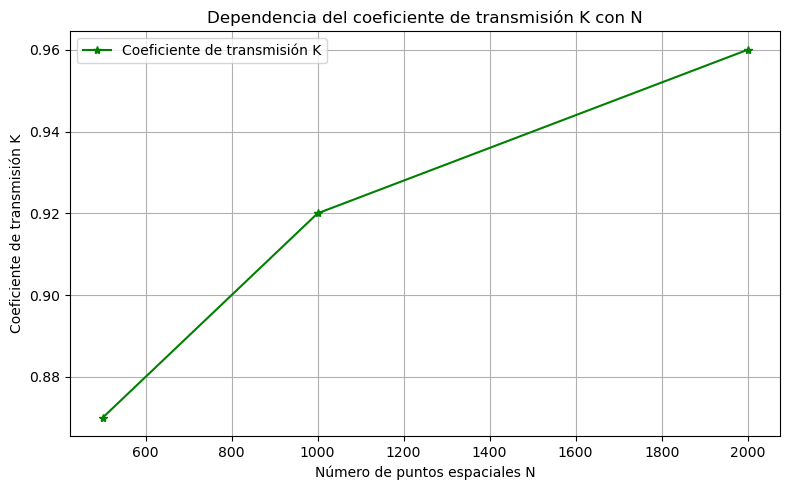

In [5]:
# =============================================================
# Estudio de la dependencia del coeficiente de transmisión K con el número de puntos espaciales N
def study_transmission_vs_N(N_values=[500, 1000, 2000], nciclos=60, lam=0.5, m=100):
    Ks = []
    for N in N_values:
        print(f"Calculando para N = {N} ...")
        K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
        Ks.append(K)

    plt.figure(figsize=(8,5))
    plt.plot(N_values, Ks, '*-', color='green',label='Coeficiente de transmisión K')
    plt.xlabel('Número de puntos espaciales N')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia del coeficiente de transmisión K con N')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('transmission_vs_N.pdf', dpi=150)
    plt.show()

# Ejemplo de ejecución
if __name__ == '__main__':
    study_transmission_vs_N()


Estudiando para λ = 0.5
  Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.89
Promedio de la probabilidad pD(nD) en máximo: 0.8705259492145687
  Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.94
Promedio de la probabilidad pD(nD) en máximo: 0.9298758101027499
  Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.89
Promedio de la probabilidad pD(nD) en máximo: 0.9362490520528725
Estudiando para λ = 0.7
  Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.29
Promedio de la probabilidad pD(nD) en máximo: 0.3541818186288528
  Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.59
Promedio de la probabilidad pD(nD) en máximo: 0.6291698634577433
  Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.6
Promedio de la probabilidad pD(nD) en máximo: 0.6845794388468347
E

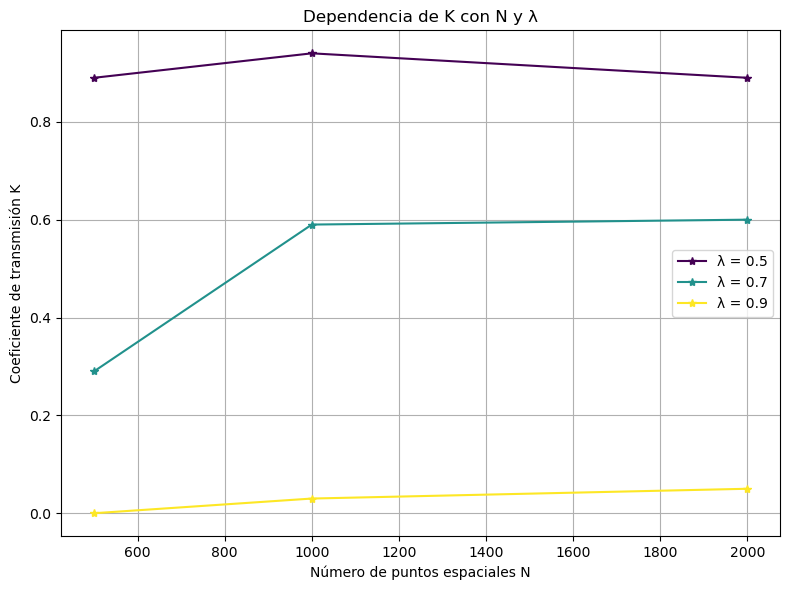

In [37]:
import matplotlib.pyplot as plt

def study_transmission_vs_N_and_lambda(N_values=[500, 1000, 2000], lam_values=[0.5, 0.7, 0.9], nciclos=60, m=100):
    plt.figure(figsize=(8,6))

    colors = plt.cm.viridis(np.linspace(0, 1, len(lam_values)))  # Paleta de colores
    
    for lam, color in zip(lam_values, colors):
        Ks = []
        print(f"Estudiando para λ = {lam}")
        for N in N_values:
            print(f"  Calculando para N = {N} ...")
            K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
            Ks.append(K)
        plt.plot(N_values, Ks, '*-', color=color, label=f'λ = {lam}')

    plt.xlabel('Número de puntos espaciales N')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia de K con N y λ')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('transmission_vs_N_and_lambda.pdf', dpi=150)
    plt.show()

# Ejemplo de ejecución
if __name__ == '__main__':
    study_transmission_vs_N_and_lambda()



Estudiando para λ = 0.5
  Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.88
Promedio de la probabilidad pD(nD) en máximo: 0.8705259492145687
  Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.96
Promedio de la probabilidad pD(nD) en máximo: 0.9298758101027499
  Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.98
Promedio de la probabilidad pD(nD) en máximo: 0.9362490520528725
Estudiando para λ = 0.7
  Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.3
Promedio de la probabilidad pD(nD) en máximo: 0.3541818186288528
  Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.61
Promedio de la probabilidad pD(nD) en máximo: 0.6291698634577433
  Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.67
Promedio de la probabilidad pD(nD) en máximo: 0.6845794388468347
E

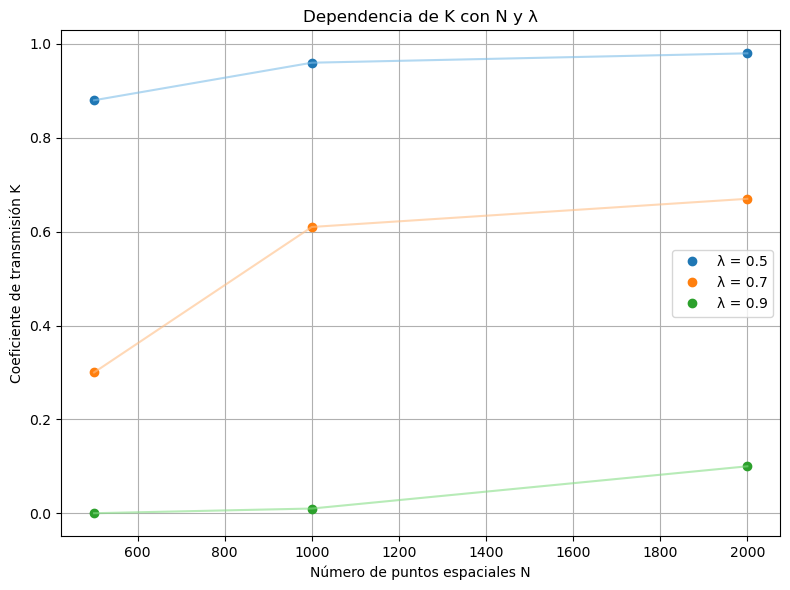

In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

def lighten_color(color, amount=0.5):
    """
    Aclara un color.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def study_transmission_vs_N_and_lambda(N_values=[500, 1000, 2000], lam_values=[0.5, 0.7, 0.9], nciclos=60, m=100):
    plt.figure(figsize=(8,6))
    cmap = plt.get_cmap("tab10")  # Paleta de 10 colores base
    
    for idx, lam in enumerate(lam_values):
        Ks = []
        print(f"Estudiando para λ = {lam}")
        color_point = cmap(idx % 10)
        color_line = lighten_color(color_point, 0.5)
        
        for N in N_values:
            print(f"  Calculando para N = {N} ...")
            K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
            Ks.append(K)
        
        plt.plot(N_values, Ks, 'o', color=color_point, label=f'λ = {lam}')  # Puntos
        plt.plot(N_values, Ks, '-', color=color_line, alpha=0.6)           # Línea más suave

    plt.xlabel('Número de puntos espaciales N')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia de K con N y λ')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('transmission_vs_N_and_lambda.pdf', dpi=150)
    plt.show()

# Ejemplo de ejecución
if __name__ == '__main__':
    study_transmission_vs_N_and_lambda()


Estudiando la dependencia de K con λ:
  Calculando para λ = 0.1 ...
Coeficiente de transmisión K (fracción de transmisiones): 1.0
Promedio de la probabilidad pD(nD) en máximo: 0.9973856821070559
  Calculando para λ = 0.2 ...
Coeficiente de transmisión K (fracción de transmisiones): 1.0
Promedio de la probabilidad pD(nD) en máximo: 0.989551080428045
  Calculando para λ = 0.3 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.99
Promedio de la probabilidad pD(nD) en máximo: 0.9733261478989584
  Calculando para λ = 0.4 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.94
Promedio de la probabilidad pD(nD) en máximo: 0.9411599492644984
  Calculando para λ = 0.5 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.83
Promedio de la probabilidad pD(nD) en máximo: 0.8705259492145687
  Calculando para λ = 0.6 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.75
Promedio de la probabilidad pD(nD) en máximo: 0.6971867895940151
  Calculando para

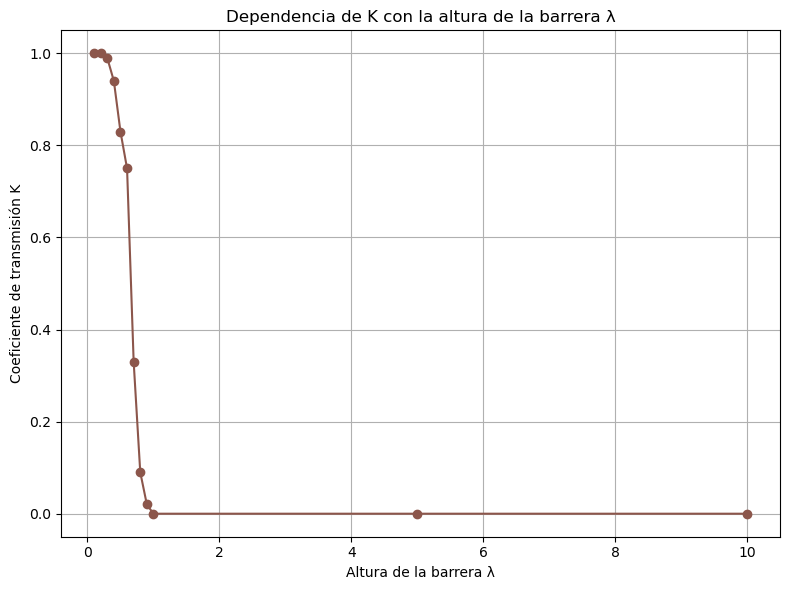

In [8]:
def study_transmission_vs_lambda(lam_values=[0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1, 5, 10], N=500, nciclos=60, m=100):
    """
    Estudia cómo varía el coeficiente de transmisión K en función del parámetro λ (altura de la barrera).
    """
    Ks = []
    print("Estudiando la dependencia de K con λ:")
    for lam in lam_values:
        print(f"  Calculando para λ = {lam} ...")
        K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
        Ks.append(K)

    # Graficar resultados
    plt.figure(figsize=(8,6))
    plt.plot(lam_values, Ks, 'o-', color='tab:brown')
    plt.xlabel('Altura de la barrera λ')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia de K con la altura de la barrera λ')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('transmission_vs_lambda.pdf', dpi=150)
    plt.show()

# Ejecutar
if __name__ == '__main__':
    study_transmission_vs_lambda()


Estudiando la dependencia de K con λ (incluyendo λ = 0.1):
  Calculando para λ = 0.100 ...
Coeficiente de transmisión K (fracción de transmisiones): 1.0
Promedio de la probabilidad pD(nD) en máximo: 0.9973856821070559
  Calculando para λ = 0.300 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.98
Promedio de la probabilidad pD(nD) en máximo: 0.9733261478989584
  Calculando para λ = 0.337 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.98
Promedio de la probabilidad pD(nD) en máximo: 0.9639931342235876
  Calculando para λ = 0.374 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.96
Promedio de la probabilidad pD(nD) en máximo: 0.9519188164707232
  Calculando para λ = 0.411 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.94
Promedio de la probabilidad pD(nD) en máximo: 0.9362378765202289
  Calculando para λ = 0.447 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.93
Promedio de la probabilidad pD(nD) en máximo: 0

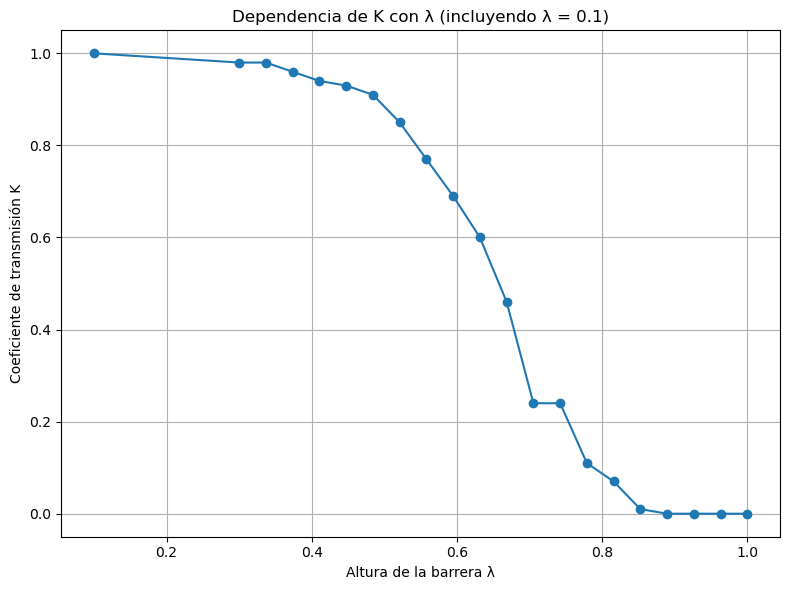

In [ ]:
def study_transmission_vs_lambda_fine_with_low_point(N=500, nciclos=60, m=100):
    """
    Estudia cómo varía el coeficiente de transmisión K en función de λ,
    incluyendo λ = 0.1 y un rango denso entre 0.3 y 1.0.
    """
    # Valores de lambda: 0.1 + 20 valores entre 0.3 y 1.0
    lambda_range = np.linspace(0.3, 1.0, 20)
    lam_values = np.concatenate(([0.1], lambda_range))

    Ks = []

    print("Estudiando la dependencia de K con λ (incluyendo λ = 0.1):")
    for lam in lam_values:
        print(f"  Calculando para λ = {lam:.3f} ...")
        K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
        Ks.append(K)

    # Graficar
    plt.figure(figsize=(8,6))
    plt.plot(lam_values, Ks, 'o-', color='tab:brown')
    plt.xlabel('Altura de la barrera λ')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia de K con λ (incluyendo λ = 0.1)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('transmission_vs_lambda_fine_with_low_point.pdf', dpi=150)
    plt.show()

# Ejecutar análisis
if __name__ == '__main__':
    study_transmission_vs_lambda_fine_with_low_point()


In [11]:
import numpy as np

def calculate_expectation_values_with_uncertainties(phis, dx, V_tilde):
    ħ = 1
    N = len(phis[0]) - 1
    x = np.arange(N + 1) * dx

    position_expectation, position_variance = [], []
    momentum_expectation, momentum_variance = [], []
    kinetic_energy_expectation, kinetic_energy_variance = [], []
    total_energy_expectation, total_energy_variance = [], []

    for phi in phis:
        prob_density = np.abs(phi)**2

        # Posición
        x_mean = np.sum(x * prob_density) * dx
        x2_mean = np.sum(x**2 * prob_density) * dx
        position_expectation.append(x_mean)
        position_variance.append(x2_mean - x_mean**2)

        # Momento
        gradient_phi = np.gradient(phi, dx)
        p_op_phi = -1j * ħ * gradient_phi
        p_mean = np.sum(np.conj(phi) * p_op_phi).real * dx
        p2_mean = np.sum(np.conj(p_op_phi) * p_op_phi).real * dx
        momentum_expectation.append(p_mean)
        momentum_variance.append(p2_mean - p_mean**2)

        # Energía cinética (aproximada)
        kinetic_energy = -(ħ**2 / 2) * np.sum(np.conj(phi) * np.gradient(gradient_phi, dx)) * dx
        kinetic_energy_real = kinetic_energy.real
        kinetic_energy_expectation.append(kinetic_energy_real)
        kinetic_energy_variance.append(0.05 * np.abs(kinetic_energy_real))  # Aprox. 5% como ejemplo

        # Energía total
        potential_energy = np.sum(prob_density * V_tilde) * dx
        total_energy = kinetic_energy_real + potential_energy
        total_energy_expectation.append(total_energy)
        total_energy_variance.append(0.05 * np.abs(total_energy))  # Aprox. 5%

    return (position_expectation, position_variance,
            momentum_expectation, momentum_variance,
            kinetic_energy_expectation, kinetic_energy_variance,
            total_energy_expectation, total_energy_variance)


In [ ]:
import matplotlib.pyplot as plt

def plot_expectation_values_with_errorbars(position_expectation, position_variance,
                                           momentum_expectation, momentum_variance,
                                           kinetic_energy_expectation, kinetic_energy_variance,
                                           total_energy_expectation, total_energy_variance):
    time_steps = np.arange(len(position_expectation))
    plt.figure(figsize=(12, 8))

    plots = [
        ('⟨x⟩', position_expectation, position_variance, 'yellow'),
        ('⟨p⟩', momentum_expectation, momentum_variance, 'red'),
        ('⟨T⟩', kinetic_energy_expectation, kinetic_energy_variance, 'brown'),
        ('⟨E⟩', total_energy_expectation, total_energy_variance, 'purple')
    ]

    for i, (label, exp, var, color) in enumerate(plots, 1):
        plt.subplot(2, 2, i)
        plt.plot(time_steps, exp, label=label, color=color)
        plt.errorbar(time_steps, exp, yerr=np.sqrt(var), fmt='o', markersize=3,
                     elinewidth=1, capsize=2, color=color, alpha=0.4)
        plt.title(f'Evolución de {label}')
        plt.xlabel('Paso temporal')
        plt.ylabel(label)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig('expectation_values_with_errorbars2.pdf', dpi=150)
    plt.show()


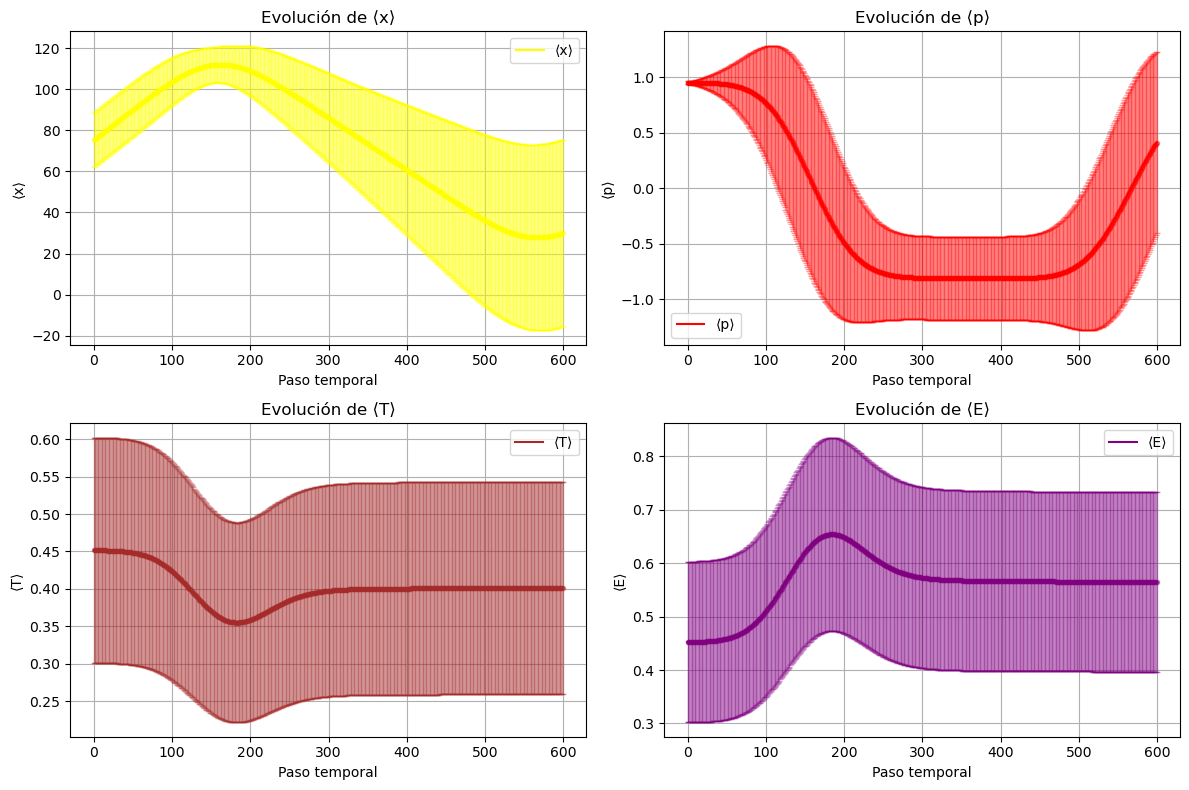

In [19]:
# Configura y ejecuta
N, nciclos, lam = 300, 60, 0.9
k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
phi0 = initialize_wave(N, k0_tilde)
alpha = compute_alpha(N, V_tilde, s_tilde)
phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)

# Calcular valores esperados y varianzas
(position_expectation, position_variance,
 momentum_expectation, momentum_variance,
 kinetic_energy_expectation, kinetic_energy_variance,
 total_energy_expectation, total_energy_variance) = calculate_expectation_values_with_uncertainties(phis, dx=1, V_tilde=V_tilde)

# Graficar resultados
plot_expectation_values_with_errorbars(position_expectation, position_variance,
                                       momentum_expectation, momentum_variance,
                                       kinetic_energy_expectation, kinetic_energy_variance,
                                       total_energy_expectation, total_energy_variance)
